Combine the catchment areas and runoff data to calculate average

In [9]:
import geopandas as gpd
import xarray as xr
import numpy as np
import rioxarray # required to use rio
import matplotlib.pyplot as plt

### User Inputs

- Rely on `catchment_areas.ipynb` for
- Use `preparation...` for...

In [2]:
catchment_geojson = 'catchment_files/stationbasins_guinea.geojson'
climatic_netcdf = 'era5_prepared_files/GN_2000_2002_monthly_t2m_tp_sro_sd_pev_e.nc'

### Loading Data

In [3]:
data_catchment = gpd.read_file(catchment_geojson)
data_climatic = xr.open_dataset(climatic_netcdf, decode_timedelta=True)


## 🔍 Estimating Streamflow at Gauging Stations Using Climatic Data

This script processes a gridded NetCDF dataset (`data_climatic.nc`) containing climatic variables such as surface runoff (`sro`), and estimates streamflow at gauging stations using catchment polygons (`stationbasins.geojson`).

### **Workflow:**
1. **Load the NetCDF climatic dataset** (e.g. ERA5 reanalysis data) using `xarray`.
2. **Extract the `sro` variable** (surface runoff) from the dataset.
3. **Load the catchment shapefile** containing polygon geometries for each station.
4. **Reproject the shapefile** to match the dataset's coordinate system.
5. **Mask and average the surface runoff** over each catchment area.
6. **Multiply the average runoff by the catchment area** to estimate **streamflow** in m³/s.
7. The result is a time series of streamflow per station, which can be used for hydropower potential estimation.

### **Assumptions:**
- Runoff (`sro`) is in units of **mm/day**.
- Catchment area is given in square kilometers and converted to m² for consistency.
- Estimate streamflow (Q) in cubic meters per second (m³/s)

In [28]:
data_runoff = data_climatic['sro']

# Set spatial dimensions
data_runoff = data_runoff.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

# Assign a CRS — make sure it's EPSG:4326 (WGS 84)
data_runoff = data_runoff.rio.write_crs("EPSG:4326")  # or .write_crs(epsg=4326)

# Reproject catchments to match dataset CRS (assuming dataset is lat/lon WGS84)
if not data_catchment.crs:
    data_catchment = data_catchment.set_crs("EPSG:4326")  # default assumption
data_catchment = data_catchment.to_crs(data_runoff.rio.crs if hasattr(data_runoff, 'rio') else "EPSG:4326")

# Convert catchments to GeoJSON-like dicts
features = data_catchment.geometry.__geo_interface__['features']

results = []

# Loop through each catchment
for i, row in data_catchment.iterrows():

    # Convert the Shapely geometry to GeoJSON format
    geom = [row['geometry'].__geo_interface__]

    # Spatial clipping operation using the rioxarray package
    runoff_cropped = data_runoff.rio.clip(geom, data_catchment.crs)

    # Average over the spatial dimensions to get a time series
    runoff_mean = runoff_cropped.mean(dim=["latitude", "longitude"])

    # Calculate area in m²
    area_km2 = row['area_calc'] if not np.isnan(row['area_calc']) else row['area']
    area_m2 = area_km2 * 1e6

    # Streamflow (Q) = runoff * area
    streamflow = (runoff_mean / 1000) * area_m2 / 86400 # units: m³/s

    streamflow = streamflow.expand_dims({"station": [row['station']]})
    results.append(streamflow)

# Combine into a DataFrame
streamflow_df = xr.concat(results, dim='station')

# Convert to DataFrame — dimensions are now fine for direct use
streamflow_df = streamflow_df.to_dataframe().reset_index().pivot(index='time', columns='station', values=streamflow_df.name)

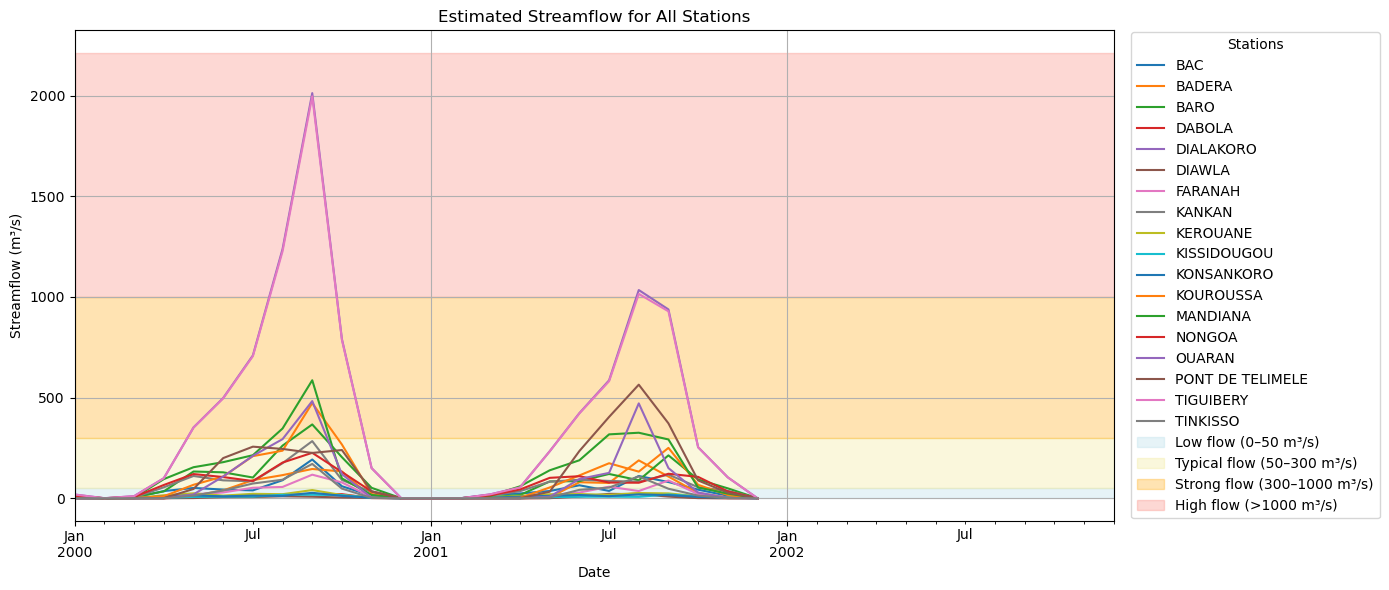

In [30]:
import matplotlib.pyplot as plt

def plot_streamflow(streamflow_df):
    """
    Simple line plot of streamflow time series for all stations,
    with legend placed outside the plot on the right.
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    streamflow_df.plot(linewidth=1.5, ax=ax)


    max_flow = streamflow_df.max().max() * 1.1  # use max from all stations
    # Define benchmark flow zones consistent with interpretation table
    ax.axhspan(0, 50, color='lightblue', alpha=0.3, label='Low flow (0–50 m³/s)')
    ax.axhspan(50, 300, color='khaki', alpha=0.3, label='Typical flow (50–300 m³/s)')
    ax.axhspan(300, 1000, color='orange', alpha=0.3, label='Strong flow (300–1000 m³/s)')
    ax.axhspan(1000, max_flow, color='salmon', alpha=0.3, label='High flow (>1000 m³/s)')

    ax.set_title("Estimated Streamflow for All Stations")
    ax.set_xlabel("Date")
    ax.set_ylabel("Streamflow (m³/s)")
    ax.grid(True)

    # Place legend outside the plot area to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.01, 0.5), title="Stations")

    plt.tight_layout()
    plt.show()

plot_streamflow(streamflow_df)

### Interpretation of Streamflow Ranges

| Streamflow (m³/s) | Interpretation                                                |
|-------------------|---------------------------------------------------------------|
| 0–50              | Likely small-to-medium catchments or dry season flows         |
| 50–300            | Very typical for West African rivers with moderate rainfall   |
| 300–600           | Strong seasonal rivers or larger catchments                   |
| 1000–2000+        | Major river flows — possibly the Niger, Tinkisso, or similar  |